In [ ]:
!pip install transformers==2.8.0

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from tqdm import tqdm

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE= ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 6, 4

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv("reviews.csv")
print(df.head(n=2))
print(df.shape)
print(df.info())

                                            reviewId      userName  \
0  gp:AOqpTOEujjLj56XVqumAkipImEqIAU3qTIuQjENPaOK...  Sam van Dijk   
1  gp:AOqpTOElISilniODwd6UBrqFngzTtDHLF-G0VLpR2_y...  Hugo Bounoua   

                                           userImage  \
0  https://lh3.googleusercontent.com/-pO3wTIb4myA...   
1  https://lh3.googleusercontent.com/a-/AOh14GgxG...   

                                             content  score  thumbsUpCount  \
0  Trash. Yes, it has some nice nifty features bu...      1             25   
1  OMG the UI is awful, seriously you have popup ...      1              8   

  reviewCreatedVersion                   at  \
0             5.2.0.23  2020-07-22 00:17:25   
1             5.2.0.23  2020-07-22 09:23:35   

                                        replyContent            repliedAt  \
0  Premium users can edit, create and delete tags...  2020-07-23 17:57:51   
1  The Premium ad only shows up when first openin...  2020-07-23 18:20:43   

       sort

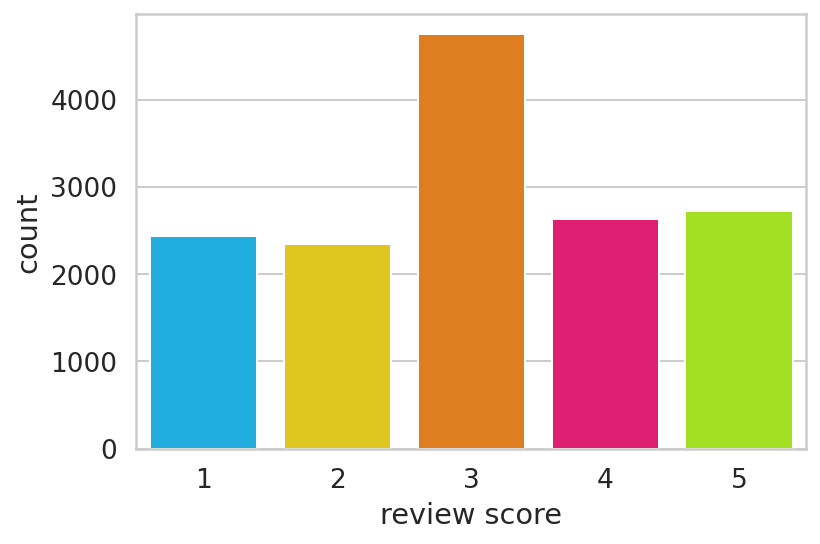

In [3]:
sns.countplot(df.score)
plt.xlabel("review score")
plt.show()

In [4]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

In [5]:
df['sentiment'] = df.score.apply(to_sentiment)

In [6]:
class_names = ['negative', 'neutral', 'positive']

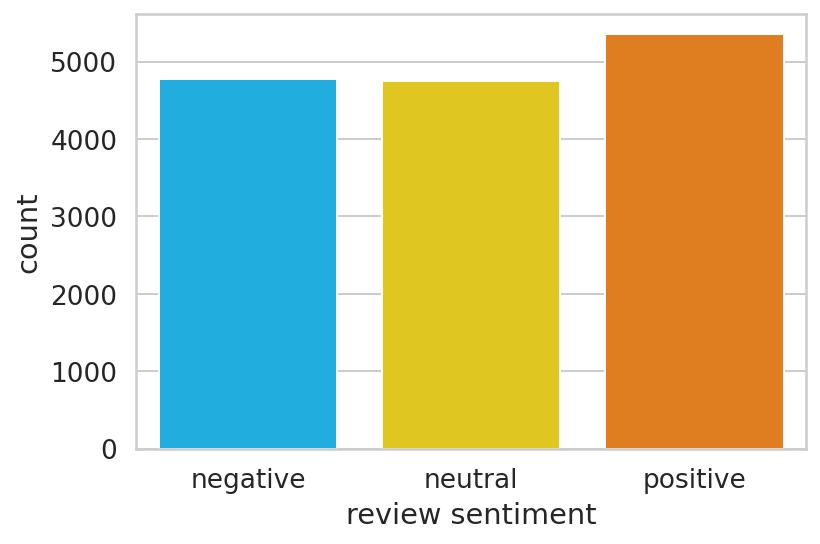

In [7]:
ax = sns.countplot(df.sentiment)
plt.xlabel("review sentiment")
ax.set_xticklabels(class_names)
plt.show()

# Data Preprocessing

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [10]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

BERT token requirements:
- special token to separate sentences
- same length sequences (padding)
- attention mask (non-padding tokens have a value of 1 in attention mask, 0 otherwise)

In [11]:
sample_txt = "When was I last outside? I am stuck at home for 2 weeks."

In [12]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f' Tokens: {tokens}')
print(f' Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
 Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
 Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### Special Tokens

In [13]:
# Separation token
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [14]:
# Classification token
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [15]:
# Padding token
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [16]:
# Unknown token
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [17]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [18]:
print(encoding['input_ids'])
print(encoding['attention_mask'])

tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


### Choosing Sequence Lenght

To choose max sequence length: check distribution of sentence lengths in dataset

In [19]:
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

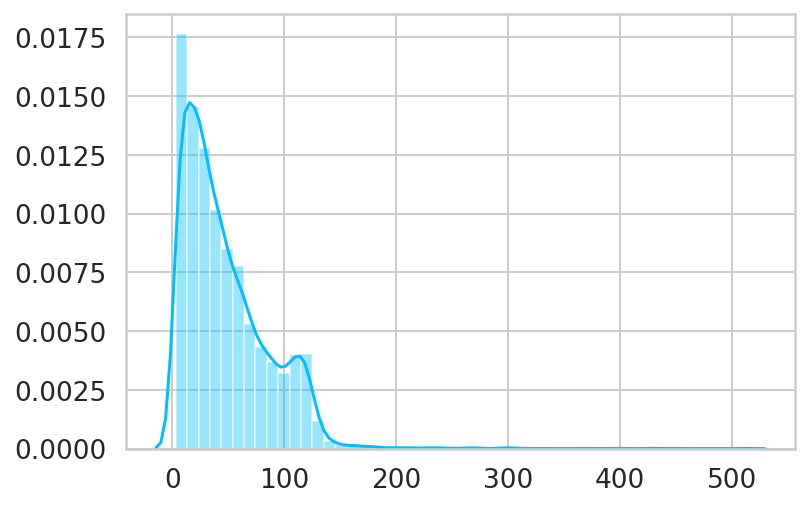

In [20]:
sns.distplot(token_lens)
plt.show()

### Create a Dataset

In [21]:
class GPReviewDataset(Dataset):
    
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, item):
        review = str(self.review[item])
        
        encoding = tokenizer.encode_plus(
        review,
        max_length=self.max_len,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.target[item], dtype=torch.long)
        }
        

In [22]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 10

In [23]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [24]:
df_train.shape, df_val.shape, df_test.shape

((11902, 13), (1488, 13), (1488, 13))

In [25]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        review=df.content.to_numpy(),
        target=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size,
        num_workers=4
    )

In [26]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [27]:
data = next(iter(train_data_loader))
print(data.keys())

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])


In [28]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# Model

In [29]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [30]:
last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'],
                                attention_mask=encoding['attention_mask'])

In [31]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [32]:
pooled_output.shape

torch.Size([1, 768])

In [33]:
bert_model.config.hidden_size

768

# Building a Sentiment Classifier

In [38]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        #self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)
        #return self.softmax(output)

In [39]:
!nvidia-smi

Wed Aug  5 12:52:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    33W / 250W |   1105MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [40]:
device = "cuda"

In [41]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [42]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


In [44]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2257, 0.3824, 0.3919],
        [0.1826, 0.3728, 0.4446],
        [0.2920, 0.4210, 0.2870],
        [0.1756, 0.5882, 0.2361],
        [0.1554, 0.2638, 0.5808],
        [0.2617, 0.1838, 0.5545],
        [0.2117, 0.2957, 0.4926],
        [0.2018, 0.5417, 0.2565],
        [0.1652, 0.5188, 0.3160],
        [0.2685, 0.2732, 0.4583],
        [0.1353, 0.3633, 0.5014],
        [0.2185, 0.3343, 0.4471],
        [0.2765, 0.3629, 0.3606],
        [0.1807, 0.4975, 0.3218],
        [0.3269, 0.2395, 0.4336],
        [0.1266, 0.4075, 0.4659]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

In [45]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [46]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [47]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [48]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        #torch.save(model, 'model.pth')
        torch.save(model.state_dict(), 'model.pth')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7237021805698512 accuracy 0.6817341623256595
Val loss 0.5904681897291573 accuracy 0.747983870967742

Epoch 2/10
----------
Train loss 0.4185749764844615 accuracy 0.8389346328348177
Val loss 0.6101765990737946 accuracy 0.790994623655914

Epoch 3/10
----------
Train loss 0.24056393173973886 accuracy 0.9211897160141154
Val loss 0.7283780996197013 accuracy 0.8165322580645162

Epoch 4/10
----------
Train loss 0.16381060197368585 accuracy 0.9524449672323979
Val loss 0.7845288631255909 accuracy 0.8326612903225807

Epoch 5/10
----------
Train loss 0.11341561765099566 accuracy 0.9683246513191061
Val loss 0.9475740696634015 accuracy 0.8333333333333334

Epoch 6/10
----------
Train loss 0.07771761062484915 accuracy 0.9776508149890775
Val loss 1.0605351332054342 accuracy 0.8346774193548387

Epoch 7/10
----------
Train loss 0.06449366577209965 accuracy 0.9813476726600572
Val loss 1.087117804154273 accuracy 0.8420698924731184

Epoch 8/10
----------
Train loss 0.0476

In [50]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('model.pth'))
model = model.to(device)

### Evaluation

In [57]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            
            texts = d['review_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return review_texts, predictions, prediction_probs, real_values

In [52]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [53]:
test_acc

tensor(0.8387, device='cuda:0', dtype=torch.float64)

In [60]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [61]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.86      0.83      0.85       482
     neutral       0.74      0.83      0.78       447
    positive       0.91      0.85      0.88       559

    accuracy                           0.84      1488
   macro avg       0.84      0.84      0.84      1488
weighted avg       0.84      0.84      0.84      1488



In [64]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')
    plt.show()

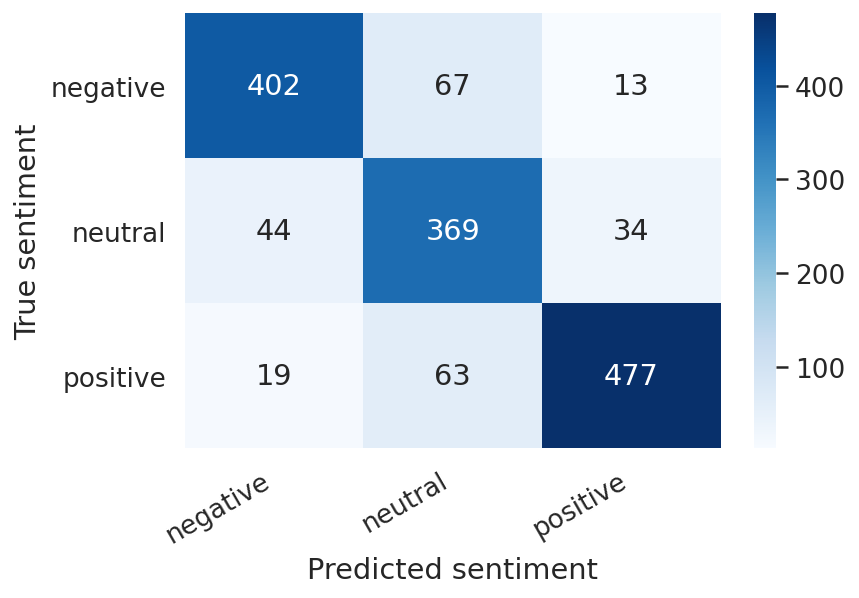

In [65]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [79]:
idx = 25

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]

pred_df = pd.DataFrame(
    {'class_names': class_names,
     'values': y_pred_probs[idx]
    }
)

In [71]:
from textwrap import wrap

In [80]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Very easy to use and convientent! O like the different options in how
you can track your goals and maintain streaks!

True sentiment: positive


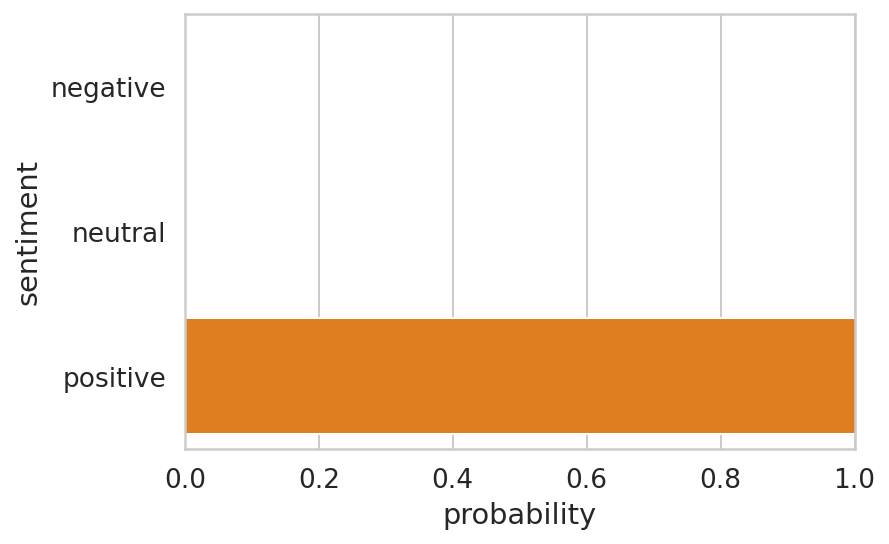

In [81]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0,1])
plt.show()

### Predict Sentiment on Raw Text

In [97]:
review_text = 'I love completing my todos. Best app EVER!!!'

In [98]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
)

In [99]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

In [100]:
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

In [101]:
print(f'Review text: {review_text}')
print(f'Sentiment : {class_names[prediction]}')

Review text: I love completing my todos. Best app EVER!!!
Sentiment : positive
